In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [4]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [5]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 4.21 s, sys: 56.1 ms, total: 4.27 s
Wall time: 4.34 s


(5000, 74)

# Normalize data

In [6]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 75)

In [8]:
Y_train = normalizer.transform(y1_list)

# Plot distribution before and after reaction

In [9]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(X_train[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(Y_train[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…

# React one more step

In [10]:
%time y2_list = kpp.onestep(np.c_[y1_list, y0_list[:,-1:]].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 1.53 s, sys: 20.4 ms, total: 1.55 s
Wall time: 2.1 s


(5000, 74)

In [11]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…

# Re-normalize data

In [12]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:74])

X_train = np.append(normalizer.transform(y1_list[:,0:74]), 
                    y0_list[:,-1:],  # use old SUN !
                    axis=1)
Y_train = normalizer.transform(y2_list)

# Fit ANN

In [13]:
x_torch = Variable(torch.from_numpy(X_train))
y_torch = Variable(torch.from_numpy(Y_train))

In [14]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).double()

In [15]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 0.011586083219795028
40 0.008443896102127405
60 0.006964113903873328
80 0.006097119770130541
100 0.005459621313597815
120 0.00501679272248742
140 0.004632510297521092
160 0.004332950707417118
180 0.004096155138208726
200 0.003916435088346591


In [16]:
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

In [17]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99922744, 0.99907555, 0.99923998, 0.99931455, 0.99929888,
       0.9993678 , 0.99864491, 0.99884803, 0.99928773, 0.99917349,
       0.99920049, 0.9964758 , 0.99752811, 0.99699481, 0.99674801,
       0.99617708, 0.99861478, 0.99556274, 0.98384289, 0.99909434,
       0.99894584, 0.9921917 , 0.99783672, 0.99675744, 0.99539618,
       0.99762626, 0.995817  , 0.9941637 , 0.99931658, 0.99844161,
       0.99843048, 0.99188143, 0.98995848, 0.94507292, 0.99582722,
       0.98675118, 0.99781739, 0.99767163, 0.91967211, 0.9993208 ,
       0.99690013, 0.99887131, 0.99933975, 0.99679872, 0.99646483,
       0.99261501, 0.9304786 , 0.99679052, 0.67022112, 0.99680479,
       0.99234908, 0.97276674, 0.8887156 , 0.9976241 , 0.99658213,
       0.99507981, 0.99744724, 0.99830578, 0.99686361, 0.99905842,
       0.99753098, 0.99902848, 0.99745373, 0.99679959, 0.99639905,
       0.99873203, 0.99776524, 0.99838155, 0.99285629, 0.99893075,
       0.99485346, 0.9982458 , 0.99828275, 0.99594623])

In [18]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9965019967469475

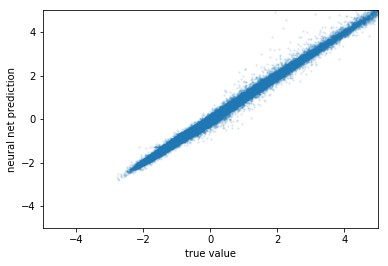

In [19]:
plt.scatter(y_pred_numpy, Y_train, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

# Test set

In [20]:
shrink = 0.0

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                           df_range['max'] - shrink*df_range['span'], 
                           size=(5000, nvar+1))

y0_test.shape

(5000, 75)

In [21]:
%%time 
y1_test = kpp.onestep(y0_test.T).T
y2_test = kpp.onestep(np.c_[y1_test, y0_test[:,-1:]].T).T  # use the same SUN as y0
y2_test.shape

CPU times: user 5.59 s, sys: 45 ms, total: 5.64 s
Wall time: 5.64 s


In [22]:
X_test = np.append(normalizer.transform(y1_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y2_test)

In [23]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 33 ms, sys: 5.78 ms, total: 38.8 ms
Wall time: 21.5 ms


In [24]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9953455674458653

In [25]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.99894933, 0.9987387 , 0.99902831, 0.99907682, 0.99905095,
       0.99908811, 0.99813728, 0.99856932, 0.99895714, 0.9991205 ,
       0.99902834, 0.99535128, 0.99676573, 0.99674855, 0.99610299,
       0.99542398, 0.99845112, 0.99413031, 0.9829058 , 0.9987534 ,
       0.998782  , 0.99118693, 0.99741791, 0.9961304 , 0.99470243,
       0.99691624, 0.99472094, 0.99392327, 0.9991122 , 0.99813794,
       0.99802527, 0.9904673 , 0.98688225, 0.93852047, 0.99490587,
       0.98502634, 0.99720391, 0.99734529, 0.89011797, 0.99906361,
       0.99642026, 0.99862352, 0.9991838 , 0.99603139, 0.99579243,
       0.98982597, 0.92292644, 0.99612755, 0.11421553, 0.99660512,
       0.99057419, 0.97312889, 0.86838545, 0.9967234 , 0.99596753,
       0.99412818, 0.99682848, 0.99795658, 0.99636942, 0.9988514 ,
       0.9969078 , 0.99884769, 0.99700089, 0.9963597 , 0.99254013,
       0.99822572, 0.99430851, 0.99807639, 0.99199964, 0.99871825,
       0.99100325, 0.9976585 , 0.99679766, 0.99523967])

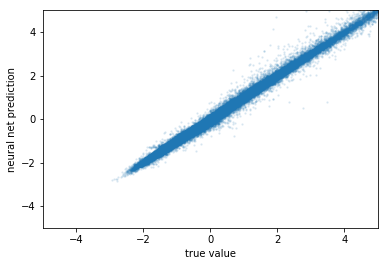

In [26]:
plt.scatter(y_test_pred, Y_test, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

In [27]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred[n,:], Y_test[n,:], 
                alpha=0.5, s=5.0)
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…

# Scale back to original concentration

In [28]:
y_test_pred_scale_back = normalizer.inverse_transform(y_test_pred)
y_test_scale_back = normalizer.inverse_transform(Y_test)

In [29]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred_scale_back[n,:], 
                y_test_scale_back[n,:], 
                alpha=0.5, s=2.0)
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…